## Packages

In [1]:
# Import packages
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from PIL import Image
from pathlib import Path
import random

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Parameters

In [2]:
# Directories
TEST_DIR_NAME = "data/test"
TRAIN_DIR_NAME = "data/train"
VAL_DIR_NAME = "data/valid"

# Image parameters
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_SIZE = 3

# Proportion of train, validation and test data
VAL_TEST_PROPORTION = 0.25 # Proportion of validation and test data to train data
TEST_PROPORTION = 0.5 # Proportion of test data to train data

# Number of images
N_TRAIN_IMAGES = 4000
N_VAL_IMAGES = (1 - TEST_PROPORTION) * VAL_TEST_PROPORTION *  N_TRAIN_IMAGES
N_TEST_IMAGES = TEST_PROPORTION * VAL_TEST_PROPORTION *  N_TRAIN_IMAGES

## Data setup

source : https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset

### Import images and labels

In [3]:
# Function to import images and labels
def import_images_and_labels(import_path_name, n_images):
    import_dir = Path(import_path_name)

    images = []
    labels = []
    
    i = 0
    for directory in os.listdir(import_dir):
        i = 0
        if directory != ".DS_Store":
            for file_name in os.listdir(import_dir / directory):
                if file_name != ".DS_Store":
                    image_path = import_dir / directory / file_name
                    image = np.array(Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT)))/255
                    images.append(image)
                    labels.append(directory)
                    i += 1
                    if i >= n_images/2:
                        break
    return np.array(images), np.array(labels)

In [4]:
# Import train data
X_train, y_label_train = import_images_and_labels(TRAIN_DIR_NAME, N_TRAIN_IMAGES)

# Import validation data
X_val, y_label_val = import_images_and_labels(VAL_DIR_NAME, N_VAL_IMAGES)

# Import test data
X_test, y_label_test = import_images_and_labels(TEST_DIR_NAME, N_TEST_IMAGES)

### Replace labels with numbers
1 : wildfire 

0 : no wildfire

In [5]:
# Function to replace labels with binary numbers
# 1 : wildfire
# 0 : no wildfire
def replace_labels(labels):
    y = []
    for label in labels:
        if label == 'wildfire':
            y.append(1)
        else:
            y.append(0)
    return np.array(y)

In [6]:
y_train = replace_labels(y_label_train)
y_val = replace_labels(y_label_val)
y_test = replace_labels(y_label_test)

### Visualisation

In [7]:
print('Dimdensions of dataset (number of images, width, height, channels), (number of labels, ) :')
print('Train : ' + str(X_train.shape) + ', ' + str(y_train.shape))
print('Validation : ' + str(X_val.shape) + ', ' + str(y_val.shape))
print('Test : ' + str(X_test.shape) + ', ' + str(y_test.shape))

Dimdensions of dataset (number of images, width, height, channels), (number of labels, ) :
Train : (4000, 64, 64, 3), (4000,)
Validation : (500, 64, 64, 3), (500,)
Test : (500, 64, 64, 3), (500,)


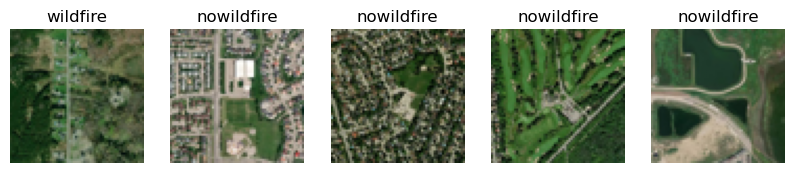

In [8]:
# Display random images
n_images_display = 5 # Number of images to display

random_indices = random.sample(range(len(X_train)), n_images_display)
random_images = [X_train[i] for i in random_indices]
random_labels = [y_label_train[i] for i in random_indices]

fig, axes = plt.subplots(1, n_images_display, figsize=(10, 5))

for i in range(n_images_display):
    axes[i].imshow(random_images[i])
    axes[i].set_title(random_labels[i])
    axes[i].axis('off')

plt.show()

## Model

### Build of CNN model

In [9]:
model1 = Sequential([
        Conv2D(16,(3,3),padding='same', activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_SIZE), name='conv_1'),
        Conv2D(8,(3,3),padding='same', activation='relu', name='conv_2'),
        MaxPooling2D((8,8), name='pool'),
        Flatten(name='flatten'),
        Dense(32, activation='relu', name='dense_1'),
        Dense(1,activation='sigmoid', name='dense_2')
    ])

model1.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool (MaxPooling2D)             │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,057 (70.54 KB)

 Trainable params: 18,057 (70.54 KB)

 Non-trainable params: 0 (0.00 B)

### Compilation

In [10]:
model1.compile(optimizer='adam',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

### Initial accuracy

In [11]:
initial_test_loss, initial_test_acc = model1.evaluate(x=X_train, y=y_train, verbose=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8414 - loss: 0.5605


### Training

In [12]:
n_epochs = 15
history = model1.fit(X_train, y_train,
                    epochs=n_epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6813 - loss: 0.5005 - val_accuracy: 0.9340 - val_loss: 0.1975
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9017 - loss: 0.2500 - val_accuracy: 0.9360 - val_loss: 0.1820
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9069 - loss: 0.2277 - val_accuracy: 0.9420 - val_loss: 0.1820
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9017 - loss: 0.2426 - val_accuracy: 0.9500 - val_loss: 0.1621
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9182 - loss: 0.2126 - val_accuracy: 0.9420 - val_loss: 0.1788
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9227 - loss: 0.2019 - val_accuracy: 0.9500 - val_loss: 0.1647
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9165 - loss: 0.2041 - val_accuracy: 0.9440 - val_loss: 0.1566
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9226 - loss: 0.2002 - val_accu

### Evaluation

In [13]:
score = model1.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: ', round(score[1], 3))

Test accuracy:  0.948


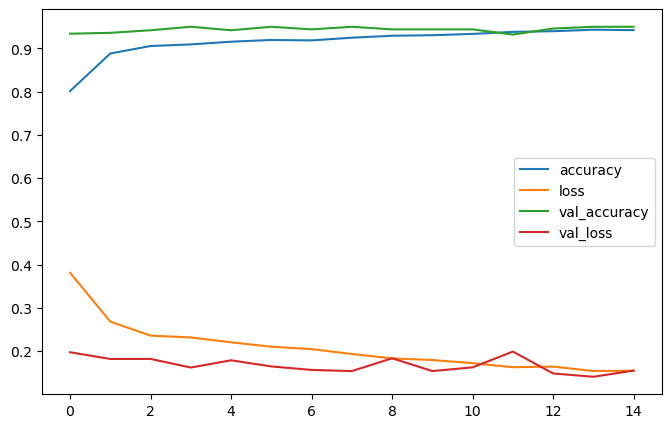

In [14]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

### Confusion Matrix

In [15]:
y_pred = model1.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [16]:
y_pred.shape

(500, 1)

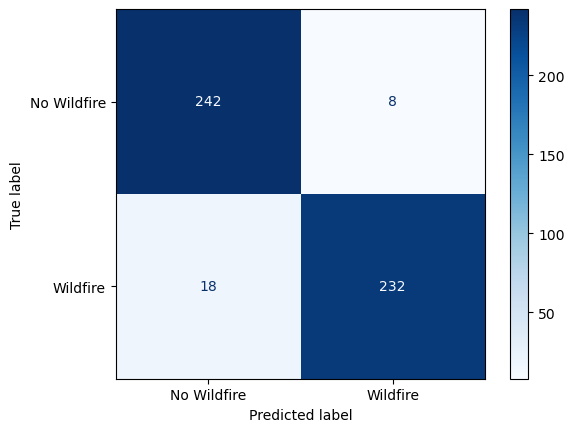

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Wildfire", "Wildfire"])
disp.plot(cmap=plt.cm.Blues)
plt.show()